In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

import torch.optim as optim


# Data preprocessing utils : 
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader

# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# my defined model
from utils.acdc_dataset import *
from utils.funcs import *
from utils.vqvae import *
from utils.launcher_utils import *

import json


In [ ]:

def load_model_from_metadata(json_filepath):
    """
    Load model parameters from a JSON file and instantiate a new model.

    Args:
        json_filepath (str): Path to the JSON file containing the metadata.

    Returns:
        model: A new instance of the model with the saved parameters.
    """
    # Load the JSON file
    with open(json_filepath, 'r') as f:
        metadata = json.load(f)

    # Extract model parameters from the metadata
    model_params = metadata.get("model_parameters", {})
    print("Loaded model parameters:", model_params)

    # Instantiate a new model with the extracted parameters
    model = VQVAE(**model_params)

    return model


In [ ]:

L = 128  # length of input images
data_modality = 'SEG'  # either 'SEG' to use segmentation dataset or 'MRI' for gray-scale MRIs
BATCH_SIZE = 32


#################### dataset init ######################
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


train_dataset = load_dataset(train_set_path, modality= data_modality)
test_dataset  = load_dataset(test_set_path, modality= data_modality)


if data_modality == 'SEG':
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        One_hot_Transform(num_classes=4)
        ])
else : 
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        PercentileClip(lower_percentile=1, upper_percentile=99),
        MinMaxNormalize(min_value=0.0, max_value=1.0),
        ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = False)




In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/tmp/ipykernel_3462442/3799642468.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [22]:

model_path = 'saved_models/seg_kwargs/500.pth'
checkpoint = torch.load(model_path)
model_metdat = (model_path).replace('.pth', '.json')
model = load_model_from_metadata(model_metdat).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

Loaded model parameters: {'embedding_dim': 64, 'num_embeddings': 512, 'downsampling_factor': 8, 'residual': False, 'num_quantizers': 2, 'shared_codebook': False, 'beta': 0.25, 'decay': 0.8, 'data_mod': 'SEG', 'loss_func': None}


/tmp/ipykernel_3462442/973086105.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [23]:
##### Evaluate the model #####
print(score_model(model, TestLoader, device))
print(checkpoint['epoch'])

0.9179373769199147
45


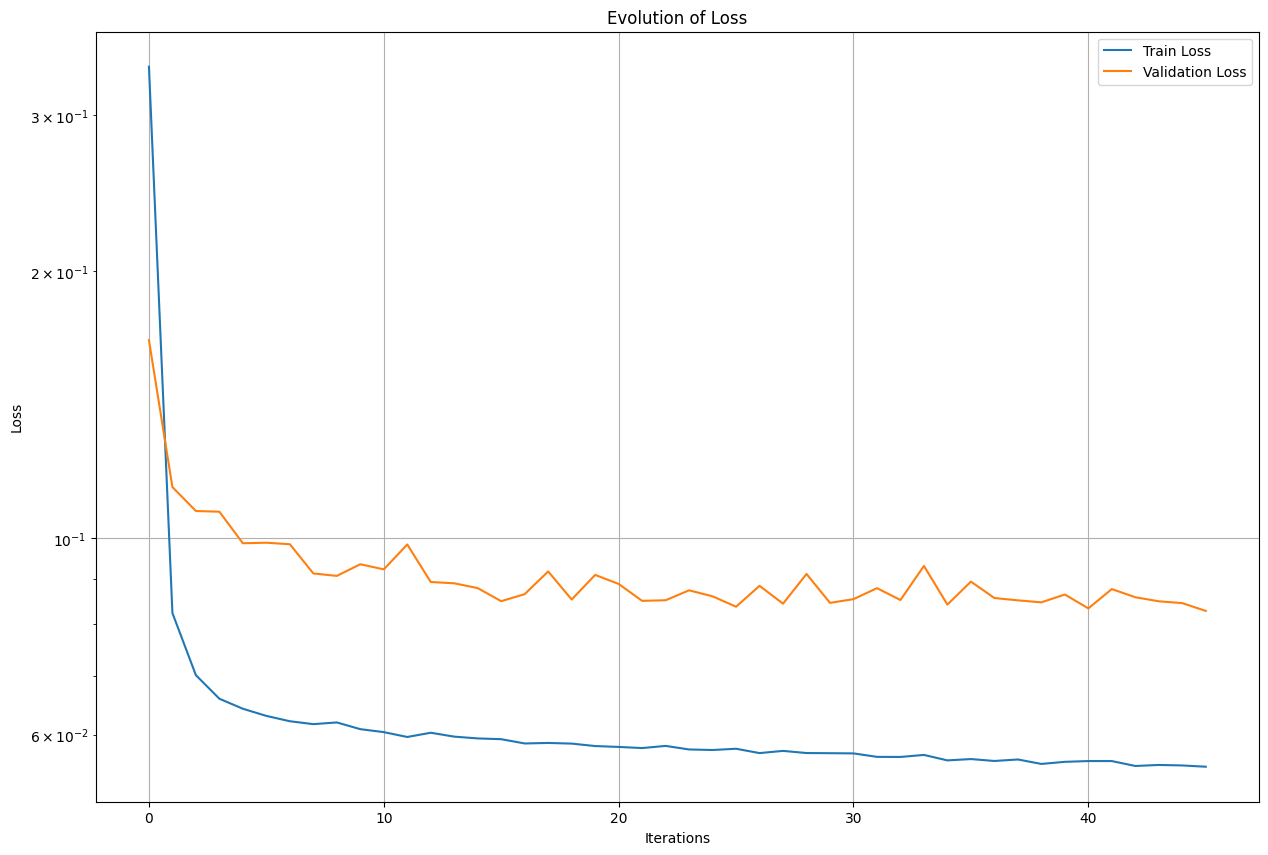

In [24]:
### PLOT loss ###

train_loss_values = checkpoint['train_loss_values']
val_loss_values = checkpoint['val_loss_values']

plot_train_val_loss(train_loss_values, val_loss_values)

ONLY 29 OF CODES WERE USED FROM 512, WHICH MAKE 5.6640625 % OF CODES FROM THE CODE-BOOK


<BarContainer object of 512 artists>

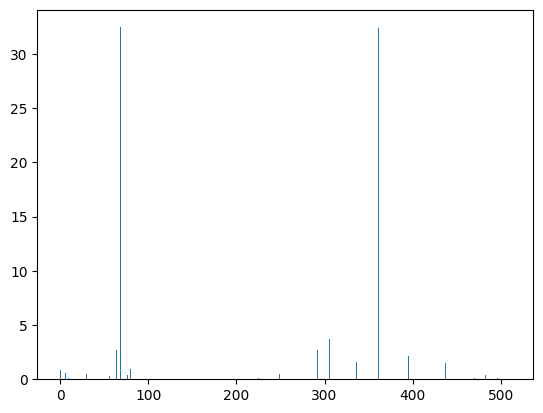

In [25]:
hist, percentage = codebook_hist_testset(model, TestLoader, device)
hist = hist/np.sum(hist)

plt.bar(np.arange(len(hist)), hist*100)